# Оптимизация производственных расходов за счет снижения энергопотребления

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель:** Построить модель, которая предскажет температуру стали. 

**Описание технологического процесса:**  

1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы 
ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.   
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
2. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.   
Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).    
3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.  
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.   
4. Затем его перемешивают и снова проводят измерения.   

Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).  

**Описание данных**  

Данные состоят из файлов, полученных из разных источников:  
- `data_arc.csv` — данные об электродах; 
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём); 
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время); 
- `data_gas.csv` — данные о продувке сплава газом; 
- `data_temp.csv` — результаты измерения температуры; 
- `data_wire.csv` — данные о проволочных материалах (объём); 
- `data_wire_time.csv` — данные о проволочных материалах (время). 

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.  


Импорт библиотек:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

## Изучение данных и EDA

### Данные об электродах

Выведем общие данные о электродах:

In [3]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [4]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Приведем к нужным типам атрибуты:

In [7]:
df_arc.columns = ['key', 'start_of_arc_heating', 'end_of_arc_heating',
       'active_power', 'reactive_power']

In [8]:
df_arc['start_of_arc_heating'] = pd.to_datetime(df_arc['start_of_arc_heating'], format='%Y-%m-%d  %H:%M:%S')
df_arc['end_of_arc_heating'] = pd.to_datetime(df_arc['end_of_arc_heating'], format='%Y-%m-%d  %H:%M:%S')

In [9]:
df_arc['start_of_arc_heating'].min(), df_arc['start_of_arc_heating'].max()

(Timestamp('2019-05-03 11:02:14'), Timestamp('2019-09-01 04:34:47'))

In [10]:
df_arc['start_of_arc_heating'].max() - df_arc['start_of_arc_heating'].min()

Timedelta('120 days 17:32:33')

In [11]:
df_arc['end_of_arc_heating'].min(), df_arc['end_of_arc_heating'].max()

(Timestamp('2019-05-03 11:06:02'), Timestamp('2019-09-01 04:36:08'))

In [12]:
df_arc['end_of_arc_heating'].max() - df_arc['end_of_arc_heating'].min()

Timedelta('120 days 17:30:06')

In [13]:
df_arc['heating_duration'] = (df_arc['end_of_arc_heating'] - df_arc['start_of_arc_heating']).dt.seconds

Провериим партии, действительно ли во всех партиях использовали электроды:

In [14]:
len(df_arc['key'].unique())

3214

In [15]:
len(set(range(1, 3242)) - set(df_arc['key']))

27

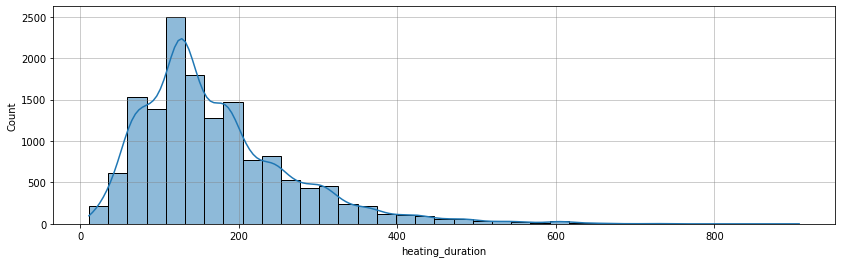

In [16]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="heating_duration", kde=True, bins=37)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

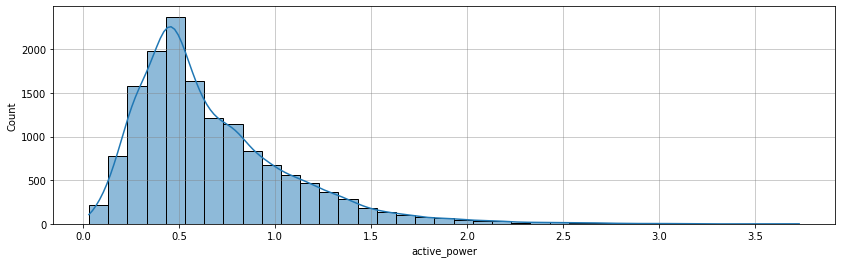

In [17]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="active_power", kde=True, bins=37)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

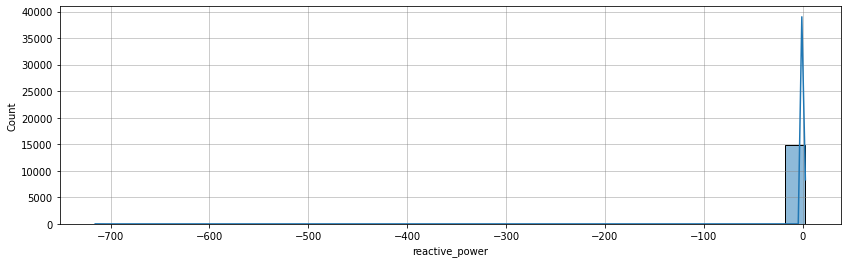

In [18]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="reactive_power", kde=True, bins=35)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

In [19]:
df_arc['reactive_power'].sort_values().head(4)

9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
Name: reactive_power, dtype: float64

In [20]:
df_arc[df_arc['reactive_power'] == min(df_arc['reactive_power'])]

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,heating_duration
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109


In [21]:
df_arc['reactive_power'] = df_arc['reactive_power'].replace(min(df_arc['reactive_power']), df_arc['reactive_power'].median())

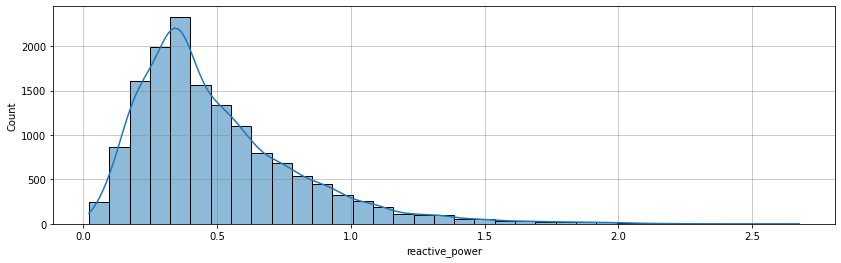

In [22]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="reactive_power", kde=True, bins=35)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

Рассчитаем полную мощность (https://m-strana.ru/articles/aktivnaya-i-reaktivnaya-moshchnost/)

In [23]:
df_arc['full_power'] = np.sqrt(df_arc['active_power']**2 + df_arc['reactive_power']**2)

In [24]:
df_arc.head()

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,heating_duration,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


In [25]:
df_arc_group = df_arc.groupby('key')[['active_power', 'reactive_power', 'heating_duration', 'full_power']].agg(['sum', 'mean']).reset_index()

In [26]:
df_arc_group.head()

key active_power           reactive_power           heating_duration  \
               sum      mean            sum      mean              sum   
0   1     4.878147  0.975629       3.183241  0.636648             1098   
1   2     3.052598  0.763150       1.998112  0.499528              811   
2   3     2.525882  0.505176       1.599076  0.319815              655   
3   4     3.209250  0.802313       2.060298  0.515074              741   
4   5     3.347173  0.836793       2.252643  0.563161              869   

          full_power            
     mean        sum      mean  
0  219.60   5.826395  1.165279  
1  202.75   3.649216  0.912304  
2  131.00   2.989534  0.597907  
3  185.25   3.814962  0.953741  
4  217.25   4.035758  1.008939

In [27]:
df_arc_group.corr().style.background_gradient(cmap='coolwarm')

In [28]:
df_arc_group = df_arc.groupby('key')[['active_power', 'reactive_power', 'heating_duration', 'full_power']].sum().reset_index()

In [29]:
df_arc_group = df_arc_group[['key', 'full_power']]

In [30]:
df_arc_group.head()

,key,full_power
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758


### Данные о подаче сыпучих материалов (объём)

In [31]:
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [32]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [33]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [34]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [35]:
df_bulk.columns = df_bulk.columns.str.replace(' ','_').str.lower()

In [36]:
len(set(range(1, 3242)) - set(df_bulk['key']))

112

In [37]:
df_bulk.columns 

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [38]:
df_bulk = df_bulk.fillna(0)

In [39]:
df_bulk['bulk_sum'] = df_bulk.drop('key', axis=1).sum(axis=1)

In [40]:
df_bulk['ratio_bulk_sum'] = df_bulk[['bulk_12', 'bulk_14', 'bulk_15']].sum(axis=1) / df_bulk.drop(['key','bulk_12', 'bulk_14', 'bulk_15'], axis=1).sum(axis=1)

In [41]:
df_bulk[['key', 'bulk_sum']].corr()

,key,bulk_sum
key,1.000000,-0.053397
bulk_sum,-0.053397,1.000000


In [42]:
df_bulk = df_bulk[['key', 'bulk_sum']]

In [43]:
df_bulk.head()

,key,bulk_sum
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0


### Данные о подаче сыпучих материалов (время)

In [44]:
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [45]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [46]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [47]:
df_bulk_time.columns = df_bulk_time.columns.str.replace(' ','_').str.lower()

In [48]:
for i in range(1, 16):
  df_bulk_time[f"bulk_{i}"] = pd.to_datetime(df_bulk_time[f"bulk_{i}"], format='%Y-%m-%d  %H:%M:%S')

In [49]:
len(set(range(1, 3242)) - set(df_bulk_time['key']))

112

### Данные о проволочных материалах (объём)

In [50]:
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [51]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [53]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [54]:
df_wire.columns = df_wire.columns.str.replace(' ','_').str.lower()

In [55]:
len(set(range(1, 3242)) - set(df_wire['key']))

160

In [56]:
df_wire = df_wire.fillna(0)

In [57]:
df_wire['wire_sum'] = df_wire.drop('key', axis=1).sum(axis=1)

In [58]:
df_wire = df_wire[['key', 'wire_sum']]

In [59]:
df_wire.head()

,key,wire_sum
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,98.352796


### Данные о проволочных материалах (время)

In [60]:
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [61]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [63]:
df_wire_time.columns = df_wire_time.columns.str.replace(' ','_').str.lower()

In [64]:
for i in range(1, 10):
  df_wire_time[f"wire_{i}"] = pd.to_datetime(df_wire_time[f"wire_{i}"], format='%Y-%m-%d  %H:%M:%S')

In [65]:
len(set(range(1, 3242)) - set(df_wire_time['key']))

160

### Данные о продувке сплава газом

In [66]:
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [67]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [68]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [69]:
df_gas.columns = ['key', 'gas_1']

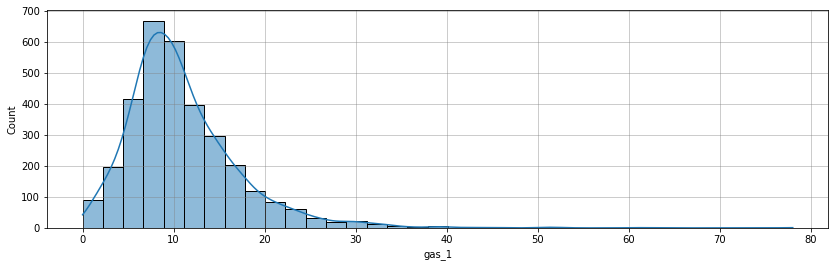

In [70]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_gas, x="gas_1", kde=True, bins=35)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

In [71]:
len(set(range(1, 3242)) - set(df_gas['key']))

2

In [72]:
df_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Результаты измерения температуры

In [73]:
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [74]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [75]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [76]:
df_temp.columns = ['key', 'sample_time', 'temperature']

In [77]:
df_temp['sample_time'] = pd.to_datetime(df_temp['sample_time'], format='%Y-%m-%d  %H:%M:%S')

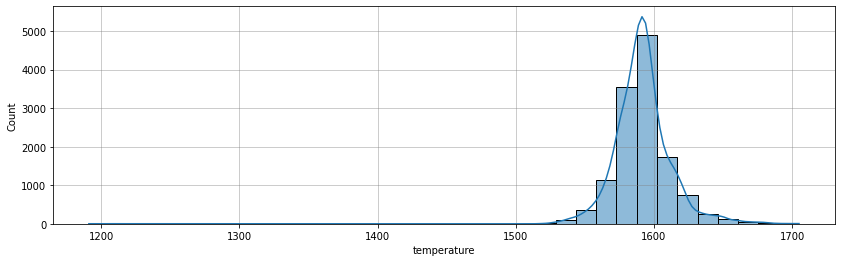

In [78]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_temp, x="temperature", kde=True, bins=35)
# plt.title('Распределение выпуска игр по годам')
# plt.ylabel('Количество')
# plt.xlabel('Год')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

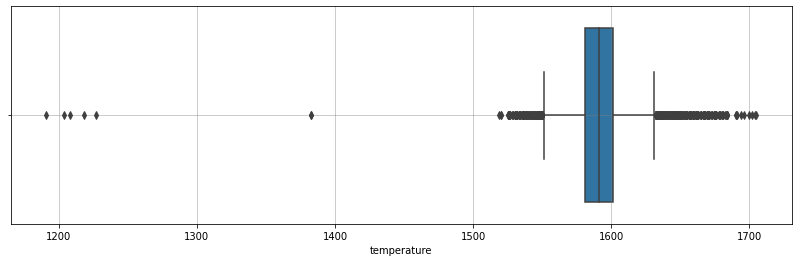

In [79]:
plt.figure(figsize=(14, 4))
sns.boxplot(x=df_temp["temperature"])
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(1980, 2017, 1))
# plt.yticks(np.arange(0, 1500, 100))
plt.show()

Взамисимости какая у нас сталь (сплав железа с углеродом), температура плавления ее может колебаться в диапазоне от 1350°С до 1535°С, при этом, наша сталь для литейного дела, и исходя из общего распределени температуры, можно сделаьт вывод, что значения ниже 1400°С являются выборосами - технологическими ошибками. [Ссылка.](http://thermalinfo.ru/svojstva-materialov/metally-i-splavy/temperatura-plavleniya-i-kipeniya-metallov-plotnost-i-teploprovodnost)  
Посмторим на партии, где температуры выбиваются из общего тренда:

In [80]:
df_temp[df_temp['temperature'] < 1400]

,key,sample_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [81]:
df_temp[(df_temp['key'] == 867)]

,key,sample_time,temperature
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0


Хоть температура ниже 1400 не плавят сталь, в полне возможно, что было низкокачественное сырье, а может быть большое кол-во присадок, поэтому не будем трогать целевую пременную.

Высокие температуру также могут сказать на конечном продукте, посмотрим на них:

In [82]:
df_temp[df_temp['temperature'] > 1700]

,key,sample_time,temperature
1794,330,2019-05-15 17:29:26,1704.0
1795,330,2019-05-15 17:30:51,1705.0
8904,1817,2019-07-06 23:47:28,1702.0


Посмотрим на количество партий, в которых не делались замеры температуры:

In [83]:
len(set(range(1, 3242)) - set(df_temp['key']))

25

Сгруппируем данные:

In [84]:
df_temp_group = pd.pivot_table(df_temp, values=['sample_time', 'temperature'], index=['key'],
                    aggfunc={'sample_time': [np.min, np.max, 'count'],
                             'temperature': [np.min, np.max, np.mean, 'first', 'last']}).reset_index()

In [85]:
df_temp_group.columns = df_temp_group.columns.droplevel(0)
df_temp_group.columns = ['key', 'time_first', 'time_last', 'count', 'temp_min', 'temp_max', 'temp_mean', 'temp_first', 'temp_last']

In [86]:
df_temp_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         3216 non-null   int64         
 1   time_first  3216 non-null   datetime64[ns]
 2   time_last   3216 non-null   datetime64[ns]
 3   count       3216 non-null   int64         
 4   temp_min    3216 non-null   float64       
 5   temp_max    3216 non-null   float64       
 6   temp_mean   3216 non-null   float64       
 7   temp_first  3216 non-null   float64       
 8   temp_last   3216 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 226.2 KB


In [87]:
df_temp_group.loc[df_temp_group['temp_first'].isna()]

,key,time_first,time_last,count,temp_min,temp_max,temp_mean,temp_first,temp_last


In [88]:
# df_temp_group = df_temp_group.drop(labels=2538, axis=0)

In [89]:
df_temp_group['duration_temp_measurement'] = (df_temp_group['time_first'] - df_temp_group['time_last']).dt.seconds

In [90]:
df_temp_group = df_temp_group[['key', 'count', 'temp_min', 'temp_max', 'temp_mean', 'temp_first', 'temp_last']]

In [91]:
df_temp_group.corr().style.background_gradient(cmap='coolwarm')

,key,count,temp_min,temp_max,temp_mean,temp_first,temp_last
key,1.000000,-0.042250,-0.208986,0.109319,0.001630,-0.127633,-0.059468
count,-0.042250,1.000000,0.194915,-0.026356,0.105986,0.075474,0.113957
temp_min,-0.208986,0.194915,1.000000,0.598074,0.720871,0.868802,0.922269
temp_max,0.109319,-0.026356,0.598074,1.000000,0.879760,0.634147,0.809904
temp_mean,0.001630,0.105986,0.720871,0.879760,1.000000,0.562458,0.802827
temp_first,-0.127633,0.075474,0.868802,0.634147,0.562458,1.000000,0.910076
temp_last,-0.059468,0.113957,0.922269,0.809904,0.802827,0.910076,1.000000


In [92]:
df_temp_group = df_temp_group[['key', 'count', 'temp_last']]

In [93]:
df_temp_group.head()

,key,count,temp_last
0,1,5,1601.400000
1,2,6,1593.500000
2,3,5,1597.800000
3,4,3,1616.333333
4,5,2,1589.000000


### Объеденение DataFrames

In [94]:
df_list = [df_bulk, df_gas, df_wire] #df_bulk_time, df_wire_time

In [95]:
df = df_temp_group.merge(df_arc_group, on='key', how='left')
for i in df_list:
  df = df.merge(i, on='key', how='left')

In [96]:
df.head()

,key,count,temp_last,full_power,bulk_sum,gas_1,wire_sum
0,1,5,1601.400000,5.826395,553.0,29.749986,60.059998
1,2,6,1593.500000,3.649216,582.0,12.555561,96.052315
2,3,5,1597.800000,2.989534,544.0,28.554793,91.160157
3,4,3,1616.333333,3.814962,595.0,18.841219,89.063515
4,5,2,1589.000000,4.035758,584.0,5.413692,98.352796


In [97]:
df.corr().style.background_gradient(cmap='cividis')

,key,count,temp_last,full_power,bulk_sum,gas_1,wire_sum
key,1.000000,-0.042250,-0.059468,-0.036766,-0.053397,-0.043313,-0.032916
count,-0.042250,1.000000,0.113957,0.340569,0.143190,0.345594,0.209434
temp_last,-0.059468,0.113957,1.000000,-0.191391,-0.074587,-0.021321,0.088004
full_power,-0.036766,0.340569,-0.191391,1.000000,0.537226,0.359554,0.085558
bulk_sum,-0.053397,0.143190,-0.074587,0.537226,1.000000,0.310672,0.013055
gas_1,-0.043313,0.345594,-0.021321,0.359554,0.310672,1.000000,0.215401
wire_sum,-0.032916,0.209434,0.088004,0.085558,0.013055,0.215401,1.000000


# План работы

## Cписок уточняющих вопросов

**Cписок уточняющих вопросов:**
1. Нужно ли время о подаче материалов и проволоки, не ясно. Точнее вообще, что со временем можно сделать. Может что-то сджойнить, или выделить день недели (вдруг на выходных как-то иначе время идет).
2. Поскольку подача сыпучик материалов и проволоки носит лишь технологический характер (например для стали 12Х хром плавится просто, ниже чем железа, поэтому примеси можно складывать, и это особо не влияет на температуру), или все-таки лучше оставить побольше атрибутов для постороения модели? Или попробывать оба варианта.
3. Целевой признак конечная температура, метрика качества MAE (должна быть не менее
4. Непонятно куда потерялись данные по замерам 25 партий. Стоил ли убрать эти данные ?


## Примерный план решения задачи

**Примерный план решения задачи:**
1. Деление на обучающую и тренировочную выборки. Выделение целевого атрибута.
2. Попробывать провести Feature engineering, с целью создание дополнительных признаков.
3. Обучение нескольких моделей.
4. Выбор лучшей (MAE не менее 7.6, но лучше ниже 6). Определение наиболее важных признаков.
5. Добавить выводы ко всем разделам, описать подробнее, что и как делал и почему.